# Making inference with pretrained UNet and B-UNet models

Define functions and set up environment

In [1]:
import torch
import sys
sys.path.append("/scratch/users/k21113539/SR-UNet")
from models.unet3d.model import BUNet3D,UNet3D

import os 
import numpy as np
import SimpleITK as sitk
import ants
%matplotlib inline
import matplotlib.pyplot as plt
import torch.nn as nn
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torchviz import make_dot
from colossalai.utils import load_checkpoint
from colossalai.initialize import launch,initialize
import colossalai
from colossalai.trainer import Trainer, hooks
import h5py as h5
from dataloaders import get_synth_dhcp_dataloader, get_synth_hcp_dataloader
import torchio as tio

from ipywidgets import interact, fixed
from IPython.display import clear_output

In [55]:
# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space.
def display_image(image_z, image):
    img = image[:, :, image_z]
    plt.imshow(sitk.GetArrayViewFromImage(img), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.show()

def load_model(model_path:str):
    model = torch.load(model_path)
    model.train()
    return model

def load_image(mode :str = 'h5', 
               paths = ['/scratch/prj/bayunet/dhcp_lores/preprocessed_h5/sub-CC01104XX07.h5'],
               dataset = 'dhcp',
               data_dir = '/home/viscent/hdd/dhcp/dhcp_lores/',):
    if mode == 'h5':
        with h5.File(paths[0],'r') as f:
            image = f['image_t1'][...].astype(np.float32)
            target = f['gt_t1'][...].astype(np.float32)
        image_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).cuda()
        target_tensor = torch.from_numpy(target).unsqueeze(0).unsqueeze(0).cuda()
        return image_tensor,target_tensor
    elif mode == 'sitk':
        image = sitk.ReadImage(paths[0])
        target = sitk.ReadImage(paths[1])
        image = sitk.GetArrayFromImage(image)
        target = sitk.GetArrayFromImage(target)
        image_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).cuda()
        target_tensor = torch.from_numpy(target).unsqueeze(0).unsqueeze(0).cuda()
        return image_tensor,target_tensor
    elif mode == 'npy':
        image = np.load(paths[0])
        target = np.load(paths[1])
        image_tensor = torch.from_numpy(image).unsqueeze(0).cuda()
        target_tensor = torch.from_numpy(target).unsqueeze(0).cuda()
        return image_tensor,target_tensor
    elif mode == 'dataloader':
        if dataset == 'dhcp':
            dataloaders, val_loader = get_synth_dhcp_dataloader(data_dir=data_dir,
                                                                batch_size=1,
                                                                num_samples=50,
                                                                input_modalities=["t1"],
                                                                output_modalities=["t1"],
                                                                output_dir=data_dir,
                                                                n_splits=5,
                                                                augmentation=False,
                                                                down_factor=5,)
        elif dataset == 'hcp':
            dataloaders, val_loader = get_synth_hcp_dataloader(data_dir=data_dir,
                                                                batch_size=1,
                                                                num_samples=50,
                                                                input_modalities=["t1"],
                                                                output_modalities=["t1"],
                                                                output_dir=data_dir,
                                                                n_splits=5,
                                                                augmentation=False,
                                                                down_factor=5,)
        image_tensor, target_tensor = next(iter(val_loader))
        image_tensor = image_tensor.cuda()
        target_tensor = target_tensor.cuda()
        return image_tensor,target_tensor

def plot_latent(model):
    encoder_weights = next(model.encoders[-1].parameters())
    encoder_weights = encoder_weights.cpu().detach().numpy()
    encoder_weights= np.expand_dims(encoder_weights,axis=1)
    encoder_weights = np.repeat(encoder_weights, 128, axis=1)
    if hasattr(model, 'enc_mu'):
        fig,(ax1,ax2) = plt.subplots(1,2)
        im1 = ax1.imshow(encoder_weights)
        ax1.set_title("encoder weights")
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im1, cax=cax, orientation="vertical")

        latent_weights = next(model.mu.parameters())
        latent_weights = latent_weights.cpu().detach().numpy()
        latent_weights = np.repeat(latent_weights, 128, axis=1)

        im2 = ax2.imshow(encoder_weights)
        ax2.set_title("latent weights")
        divider = make_axes_locatable(ax2)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im2, cax=cax, orientation="vertical")
        fig.show()
    else:
        fig = plt.imshow(encoder_weights)
        plt.title("encoder weights")
        plt.colorbar()
        plt.show()
    # plt.savefig(OUTPUT_PREFIX+"_encoder_weights.png")

def infer(model,image_tensor):
    output_tensor = model(image_tensor)
    return output_tensor

def get_metrics(output_tensor,target_tensor, model, mu_q = None, logvar_q = None):
    im = target_tensor
    im_hat = output_tensor
    mse = torch.nn.MSELoss()(im, im_hat)
    mse.backward()
    print('mse:', mse.cpu().detach().numpy())
    if hasattr(model, 'enc_mu'):
        mu_p, logvar_p = model.enc_mu,model.enc_logvar
        # kl = (0.5 * ((torch.ones_like(logvar_p)-torch.ones_like(logvar_p)) + (mu_p-mu_q)**2 / torch.ones_like(logvar_p).exp() - 1 + (torch.ones_like(logvar_p)).exp() / (torch.ones_like(logvar_p)).exp() )).sum()
        # kl = (0.5 * ((logvar_q-logvar_p) + (mu_p-mu_q)**2 / logvar_q.exp() - 1 + logvar_p.exp() / logvar_q.exp())).mean()
        kl = 0.5 * (logvar_p.exp() + mu_p**2 - 1 - logvar_p).sum()
        # kl = torch.mean(0.5 * (torch.exp(logvar_p) + torch.pow(mu_p,2) - 1 - logvar_p))
        # kl = 0.5 * ((logvar_q-logvar_p) - 3 + (mu_p - mu_q) / logvar_q.exp() * (mu_p-mu_q) + torch.trace)
        # kl = torch.sum(kl)
        FE_simple = mse + 0.00025 * kl
        print('kl:', kl.cpu().detach().numpy())
        print('Free energy:', FE_simple.cpu().detach().numpy())

def plot_output(image_tensor,output_tensor,target_tensor):
    image_tensor = image_tensor.cpu().squeeze().squeeze().detach().numpy().astype(np.float32)
    output_tensor = output_tensor.cpu().squeeze().squeeze().detach().numpy().astype(np.float32)
    target_tensor = target_tensor.cpu().squeeze().squeeze().detach().numpy().astype(np.float32)
    fig,(ax1,ax2,ax3) = plt.subplots(1,3)
    im1 = ax1.imshow(image_tensor[image_tensor.shape[0]//2,:,:],cmap='gray')
    ax1.set_title("image")


    im2 = ax2.imshow(output_tensor[output_tensor.shape[0]//2,:,:],cmap='gray')
    ax2.set_title("output")
    
    
    im3 = ax3.imshow(target_tensor[target_tensor.shape[0]//2,:,:],cmap='gray')
    ax3.set_title("target")
    fig.show()
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))
    
def registration_sitk(fixed_image, moving_image):
    initial_transform = sitk.CenteredTransformInitializer(
        fixed_image,
        moving_image,
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY,
    )

    moving_resampled = sitk.Resample(
        moving_image,
        fixed_image,
        initial_transform,
        sitk.sitkLinear,
        0.0,
        moving_image.GetPixelID(),
    )
    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings.
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    registration_method.SetInterpolator(sitk.sitkLinear)

    # Optimizer settings.
    registration_method.SetOptimizerAsGradientDescent(
        learningRate=1.0,
        numberOfIterations=100,
        convergenceMinimumValue=1e-6,
        convergenceWindowSize=10,
    )
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)


    final_transform = registration_method.Execute(
        sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32)
    )
    moving_resampled = sitk.Resample(
        moving_image,
        fixed_image,
        final_transform,
        sitk.sitkLinear,
        0.0,
        moving_image.GetPixelID(),
    )
    return moving_resampled

def resample(image):
    target_shape = (108, 145, 145)
    spacing = [1.0,1.0,1.0]
    spacing = np.array(spacing)
    resample_transform = tio.Resample(target=spacing)
    resize_transform = tio.Resize(target_shape=target_shape)
    transform  = tio.Compose([resample_transform,resize_transform])
    return transform(image)

def downSample(image):
    spacing = [1.0,1.0,1.0]
    spacing = np.array(spacing)
    spacing *= 5
    target_shape = (108, 145, 145)
    factor = spacing[2] / spacing[0]
    resize_transform = tio.Resize(target_shape=target_shape)
    resample_transform = tio.Resample(target=spacing)
    blur_transform = tio.RandomBlur(3)
    transform  = tio.Compose([resample_transform,resize_transform,blur_transform])
    return transform(image)


def registration_ants(fixed_image, moving_image):
    fixed_array = sitk.GetArrayFromImage(fixed_image)
    moving_array = sitk.GetArrayFromImage(moving_image)
    fixed_ants = ants.from_numpy(fixed_array)
    moving_ants = ants.from_numpy(moving_array)
    ret = ants.registration(fixed_ants, moving_ants,verbose=True)
    image = ret['warpedmovout'].numpy()
    image = sitk.GetImageFromArray(image)
    image.CopyInformation(fixed_image)
    return image

In [3]:
with h5.File('/scratch/prj/bayunet/dhcp_lores/preprocessed_h5/sub-CC01104XX07.h5', 'r') as hf:
    image_t1 = hf['image_t1'][()]
    image_t2 = hf['image_t2'][()]
    gt_t1 = hf['gt_t1'][()]
    gt_t2 = hf['gt_t2'][()]
    image_t1 = sitk.GetImageFromArray(image_t1)
    image_t2 = sitk.GetImageFromArray(image_t2)
    gt_t1 = sitk.GetImageFromArray(gt_t1)
    gt_t2 = sitk.GetImageFromArray(gt_t2)

In [4]:
interact(
    display_image,
    image_z=(0, gt_t2.GetSize()[2] - 1),
    image=fixed(gt_t2),
);

interactive(children=(IntSlider(value=72, description='image_z', max=144), Output()), _dom_classes=('widget-in…

In [18]:
model_vae_dhcp = load_model('/scratch/prj/bayunet/experiments/output_vae_dhcp_t1_800/0/checkpoints/160.pth')
model_vae_hcp = load_model('/scratch/prj/bayunet/experiments/output_vae_hcp_t1_800/0/checkpoints/91.pth')
model_unet_dhcp = load_model('/scratch/prj/bayunet/experiments/output_unet_dhcp_t1_800/0/checkpoints/160.pth')
model_unet_hcp = load_model('/scratch/prj/bayunet/experiments/output_unet_hcp_t1_800/0/checkpoints/91.pth')

mu_vae_dhcp = model_vae_dhcp.enc_mu
logvar_vae_dhcp = model_vae_dhcp.enc_logvar
mu_vae_hcp = model_vae_hcp.enc_mu
logvar_vae_hcp = model_vae_hcp.enc_logvar

In [19]:
# optim_vae_dhcp = torch.optim.Adam(
#     model_vae_dhcp.parameters(),
#     lr=0.001,
#     betas=(0.9, 0.99)
# )
# optim_vae_hcp = torch.optim.Adam(
#     model_vae_hcp.parameters(),
#     lr=0.001,
#     betas=(0.9, 0.99)
# )

# criteria = nn.MSELoss()

## Results on dHCP

In [56]:
image_tensor,target_tensor = load_image()
image_tensor_dHCP = image_tensor.clone()
target_tensor_dHCP = target_tensor.clone()

In [57]:
mu_q = mu_vae_dhcp
mu_p = model_vae_dhcp.enc_mu
logvar_q = logvar_vae_dhcp
logvar_p = model_vae_dhcp.enc_logvar

In [58]:
(mu_p - mu_q)**2

tensor([[[[[2.7409e-01],
           [1.0902e+00],
           [2.4611e+00],
           ...,
           [4.7802e+00],
           [1.0878e-01],
           [1.0542e+00]],

          [[2.0512e+00],
           [3.0999e+00],
           [2.7057e-01],
           ...,
           [3.6608e+01],
           [1.7342e+00],
           [1.2819e+01]],

          [[3.3079e+00],
           [8.1325e+00],
           [7.6103e+00],
           ...,
           [1.2730e+00],
           [5.5124e+00],
           [1.1057e+00]],

          ...,

          [[2.3831e-01],
           [2.2510e+00],
           [3.9617e+01],
           ...,
           [2.9220e+01],
           [3.0409e+01],
           [5.8052e+00]],

          [[3.4662e-01],
           [3.5984e+00],
           [3.0358e+00],
           ...,
           [5.1408e+00],
           [3.7845e+00],
           [1.7310e+01]],

          [[1.9413e-02],
           [9.3905e+00],
           [7.4494e+00],
           ...,
           [1.5968e+00],
           [1.7742e-01],
   

In [59]:
kl = (0.5 * ((logvar_q-logvar_p) + (mu_p-mu_q)**2 / logvar_q.exp() - 1 + logvar_p.exp() / logvar_q.exp()))

In [60]:
logvar_q

Parameter containing:
tensor([[[[[ -9.5232],
           [ -8.8872],
           [ -6.4899],
           ...,
           [ -8.6435],
           [ -8.4957],
           [ -6.0506]],

          [[-11.6352],
           [-17.6239],
           [-23.2484],
           ...,
           [-17.7351],
           [-12.2667],
           [-11.8522]],

          [[-12.7095],
           [-23.1700],
           [-21.8029],
           ...,
           [-16.9944],
           [-14.4637],
           [-14.0280]],

          ...,

          [[ -7.8641],
           [-10.8408],
           [ -9.1066],
           ...,
           [-11.6042],
           [-16.8367],
           [ -7.5130]],

          [[-12.1091],
           [-17.1923],
           [-20.5034],
           ...,
           [-12.3343],
           [-11.5631],
           [-12.6982]],

          [[-12.3636],
           [-15.5492],
           [-16.1625],
           ...,
           [-11.2559],
           [-11.9291],
           [ -9.5687]]],


         [[[-10.3515],
 

In [61]:
kl[kl.isnan()]=0
kl[kl.isinf()]=0

In [62]:
kl.sum()

tensor(2.3624e+32, device='cuda:0')

In [63]:
model_vae_dhcp

BUNet3D(
  (encoders): ModuleList(
    (0): Encoder(
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(1, 1, eps=1e-05, affine=True)
          (conv): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
        (SingleConv2): SingleConv(
          (groupnorm): GroupNorm(1, 8, eps=1e-05, affine=True)
          (conv): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
      )
    )
    (1): Encoder(
      (pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(1, 16, eps=1e-05, affine=True)
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
       

### VAE-dHCP

mse: 0.08670566
kl: 9018.719
Free energy: 2.3413854


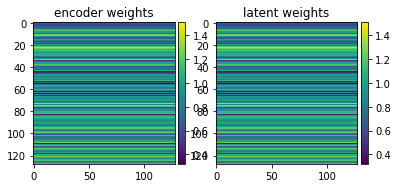

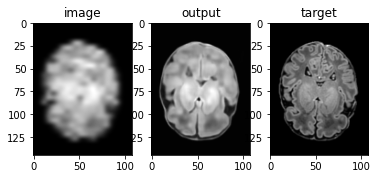

In [64]:
plot_latent(model_vae_dhcp)
output_tensor = infer(model_vae_dhcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_vae_dhcp, mu_q= mu_vae_dhcp, logvar_q= logvar_vae_dhcp)
plot_output(image_tensor,output_tensor,target_tensor)

### VAE-HCP

mse: 0.1724174
kl: 7306.8066
Free energy: 1.9991192


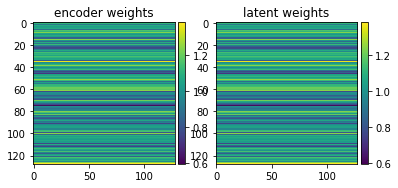

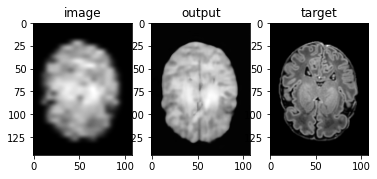

In [65]:
plot_latent(model_vae_hcp)
output_tensor = infer(model_vae_hcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_vae_hcp, mu_q= mu_vae_hcp, logvar_q= logvar_vae_hcp)
plot_output(image_tensor,output_tensor,target_tensor)

### UNET-dHCP

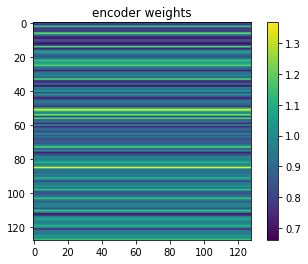

mse: 0.09564729


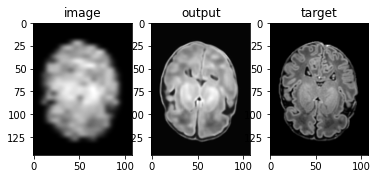

In [66]:
plot_latent(model_unet_dhcp)
output_tensor = infer(model_unet_dhcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_unet_dhcp)
plot_output(image_tensor,output_tensor,target_tensor)

### UNET-HCP

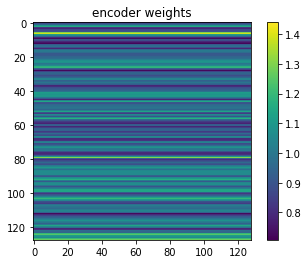

mse: 0.16792487


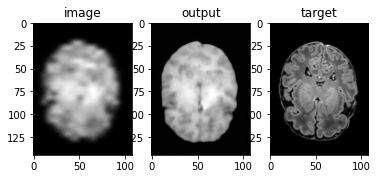

In [67]:
plot_latent(model_unet_hcp)
output_tensor = infer(model_unet_hcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_unet_hcp)
plot_output(image_tensor,output_tensor,target_tensor)

## Results on HCP

In [68]:
image_tensor,target_tensor = load_image(mode='h5',paths=['/scratch/prj/bayunet/HCP_1200/preprocessed_h5/100206.h5'])
image_tensor_HCP = image_tensor.clone()
target_tensor_HCP = target_tensor.clone()

### VAE-dHCP

mse: 0.11194014
kl: 7337.915
Free energy: 1.946419


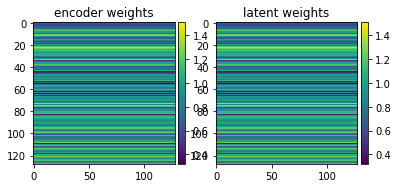

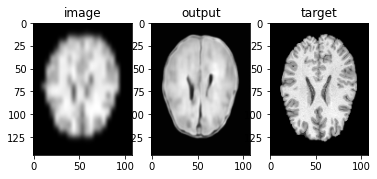

In [69]:
plot_latent(model_vae_dhcp)
output_tensor = infer(model_vae_dhcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_vae_dhcp, mu_q= mu_vae_dhcp, logvar_q= logvar_vae_dhcp)
plot_output(image_tensor,output_tensor,target_tensor)

### VAE-HCP

mse: 0.03730672
kl: 8239.566
Free energy: 2.0971985


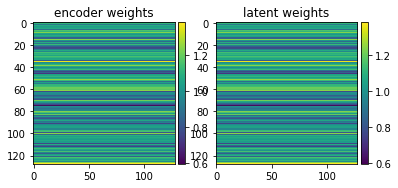

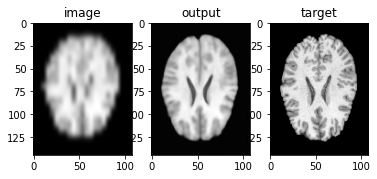

In [70]:
plot_latent(model_vae_hcp)
output_tensor = infer(model_vae_hcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_vae_hcp, mu_q= mu_vae_hcp, logvar_q= logvar_vae_hcp)
plot_output(image_tensor,output_tensor,target_tensor)

### UNET-dHCP

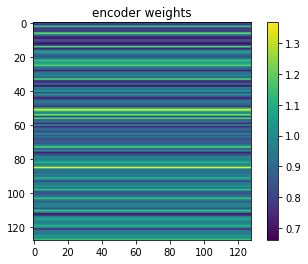

mse: 0.111206


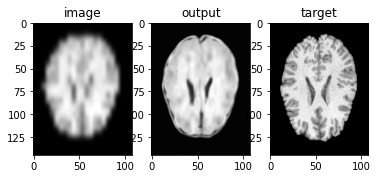

In [71]:
plot_latent(model_unet_dhcp)
output_tensor = infer(model_unet_dhcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_unet_dhcp)
plot_output(image_tensor,output_tensor,target_tensor)

### UNET-HCP

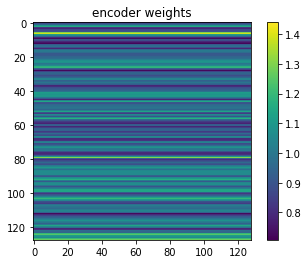

mse: 0.036210034


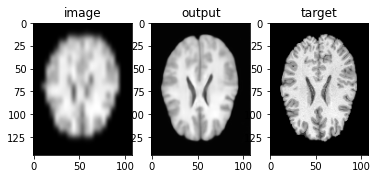

In [54]:
plot_latent(model_unet_hcp)
output_tensor = infer(model_unet_hcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_unet_hcp)
plot_output(image_tensor,output_tensor,target_tensor)

# Statistical test

In [ ]:
dataloader = 

## Cross-domain Evaluation

In [17]:
# fixed_image = sitk.ReadImage('/media/hdd/dhcp/dhcp_lores/preprocessed/sub-CC00446XX18_gt_t1.nii.gz', sitk.sitkFloat32)
# moving_image = sitk.ReadImage('/home/viscent/hdd/viscent/SR-UNet/data/001B/001B_mediumResShortTI.nii', sitk.sitkFloat32)
# moving_image = sitk.DICOMOrient(moving_image,'RAI')
# # Undo normalization

# temp_array = sitk.GetArrayFromImage(fixed_image)
# temp_array *= sitk.GetArrayFromImage(moving_image).max()
# temp_fixed = sitk.GetImageFromArray(temp_array)
# temp_fixed.CopyInformation(fixed_image)
# fixed_image = temp_fixed

# # fixed_image = downSample(fixed_image)
# moving_image = resample(moving_image)
# moving_ants = ants.from_numpy(sitk.GetArrayFromImage(moving_image))
# fixed_ants = ants.from_numpy(sitk.GetArrayFromImage(fixed_image))
# ret = ants.registration(fixed=fixed_ants, moving=moving_ants,verbose=True)
# target_tensor = torch.from_numpy(sitk.GetArrayFromImage(moving_image)).clone().unsqueeze(0).unsqueeze(0).cuda()
# image = downSample(moving_image)
# image_tensor = torch.from_numpy(sitk.GetArrayFromImage(moving_image)).unsqueeze(0).unsqueeze(0).cuda()

In [18]:
# moving_image.GetSpacing()

In [19]:
fixed_image = sitk.ReadImage('/media/hdd/dhcp/dhcp_lores/preprocessed/sub-CC00446XX18_gt_t1.nii.gz', sitk.sitkFloat32)
# moving_image = sitk.ReadImage('/media/hdd/ds001894/sub-001/ses-T1/anat/sub-001_ses-T1_T1w.nii.gz', sitk.sitkFloat32)
moving_image = sitk.ReadImage('/home/viscent/hdd/viscent/SR-UNet/data/reg.nii.gz', sitk.sitkFloat32)
# moving_image = sitk.ReadImage('/home/viscent/hdd/viscent/SR-UNet/data/T1.nii.gz', sitk.sitkFloat32)
# moving_image = sitk.DICOMOrient(moving_image,'RAI')

# Undo normalization

temp_array = sitk.GetArrayFromImage(fixed_image)
temp_array = (temp_array - temp_array.min()) / (temp_array.max() - temp_array.min()) * sitk.GetArrayFromImage(moving_image).max()
temp_fixed = sitk.GetImageFromArray(temp_array)
temp_fixed.CopyInformation(fixed_image)
fixed_image = temp_fixed

moving_image = resample(moving_image)

image = registration_ants(fixed_image,moving_image)
image = resample(image)
target_tensor = torch.from_numpy(sitk.GetArrayFromImage(image)).clone().unsqueeze(0).unsqueeze(0).cuda()
# image = downSample(image)
image_tensor = torch.from_numpy(sitk.GetArrayFromImage(image)).unsqueeze(0).unsqueeze(0).cuda()
# target_tensor = torch.clone(image_tensor).cuda()


RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "/media/hdd/dhcp/dhcp_lores/preprocessed/sub-CC00446XX18_gt_t1.nii.gz" does not exist.

In [ ]:
image = sitk.ReadImage('/home/viscent/hdd/viscent/SR-UNet/data/reg.nii.gz', sitk.sitkFloat32)
image = downSample(image)
target_tensor = torch.from_numpy(sitk.GetArrayFromImage(image)).clone().unsqueeze(0).unsqueeze(0).cuda()
# image = downSample(image)
image_tensor = torch.from_numpy(sitk.GetArrayFromImage(image)).unsqueeze(0).unsqueeze(0).cuda()
# target_tensor = torch.clone(image_tensor).cuda()

In [ ]:
interact(
    display_image,
    image_z=(0, fixed_image.GetSize()[2] - 1),
    image=fixed(downSample(fixed_image)),
);

In [ ]:
output_tensor = infer(model_unet_dhcp,image_tensor)
get_metrics(output_tensor,target_tensor,model_unet_dhcp)
plot_output(image_tensor,output_tensor,target_tensor)